***
 # Imports
***

In [174]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sn
import plotly
import plotly.express as px
import plotly.graph_objects as go

from pyod.models.knn import KNN

In [175]:
def show_values(axs, orient="v", space=.05):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2.8
                _y = p.get_y() + p.get_height() + (p.get_height()*0.02)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height() * 10)
                value = '{:.2f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [308]:
## Analisar os produtos independentes entre si e uma comparação entre si
## o estudo mostrou que o melaço, ao se comparar apenas ele com ele mesmo
## trouxe mairoes quantidades de reduções percentuais em comparação com os aumentos percentuais
## ja o biofruit trouxe mais aumentos percentuais do que reduções

## Ja uma comparação de amostras iguais e aleatorias entre eles mostra que não foram encontradas evidencias suficientes para dizer que o Biofruit é mais eficiente que o melaço ou vice-versa]
## Uma comparação do total de aplicações entre elas, sem ser iguais, mostra que existem diferenças significativas}

***
 # Tratamento
***

In [176]:
dataset = pd.read_excel('MAD_BIOFRUIT_MELACO_.xlsx')

In [177]:
dataset.head(3)

DATA_ATUAL DATA_DEPOIS  DIAS    FAZENDA VARIEDADE   PRODUTO  \
0  2019-08-22  2019-08-23     1  BOM JESUS     Tommy    Melaço   
1  2019-09-03  2019-09-04     1  BOM JESUS     Tommy    Melaço   
2  2019-09-23  2019-09-24     1  BOM JESUS     Tommy  BIOFRUIT   

                              TALHAO                     FASE  MAD  \
0  BOM JESUS - AGD BAHIA-001 - Tommy   CRESCIMENTO VEGETATIVO  0.5   
1  BOM JESUS - AGD BAHIA-001 - Tommy  AMADURECIMENTO DE RAMOS  0.0   
2  BOM JESUS - AGD BAHIA-001 - Tommy  AMADURECIMENTO DE RAMOS  0.5   

   MAD_DEPOIS  DIFERENCA_ABSOLUTA RESULTADO_MAD  
0         1.0                 0.5      AUMENTOU  
1         0.0                 0.0         IGUAL  
2         0.0                 0.5       REDUZIU

In [178]:
dataset['% Dif'] =  (dataset['DIFERENCA_ABSOLUTA'] / dataset['MAD']) * 100

In [179]:
dataset.head(2)

DATA_ATUAL DATA_DEPOIS  DIAS    FAZENDA VARIEDADE PRODUTO  \
0  2019-08-22  2019-08-23     1  BOM JESUS     Tommy  Melaço   
1  2019-09-03  2019-09-04     1  BOM JESUS     Tommy  Melaço   

                              TALHAO                     FASE  MAD  \
0  BOM JESUS - AGD BAHIA-001 - Tommy   CRESCIMENTO VEGETATIVO  0.5   
1  BOM JESUS - AGD BAHIA-001 - Tommy  AMADURECIMENTO DE RAMOS  0.0   

   MAD_DEPOIS  DIFERENCA_ABSOLUTA RESULTADO_MAD  % Dif  
0         1.0                 0.5      AUMENTOU  100.0  
1         0.0                 0.0         IGUAL    NaN

In [180]:
print(dataset['FASE'].value_counts(),'\n',dataset['VARIEDADE'].value_counts())

CRESCIMENTO VEGETATIVO      2064
AMADURECIMENTO DE RAMOS     1966
DESENVOLVIMENTO DO FRUTO    1122
FLORAÇÃO                    1076
COLHEITA                    1030
INDUÇÃO FLORAL               837
CHUMBINHO                     82
Formação                      61
FORMAÇÃO                       8
PÓS-COLHEITA                   1
Name: FASE, dtype: int64 
  Tommy             4334
 Keitt             1862
 Kent              1403
 Palmer             457
 Ommer              109
 Osteen              37
 Kent,               15
 keitt               14
 Keitt / Palmer       7
 TOMMY                1
Name: VARIEDADE, dtype: int64


In [181]:
def correcao(dataset):
    if dataset['FASE'] == 'Formação':
        return 'FORMAÇÃO'
    else:
        return dataset['FASE']
dataset['FASE'] = dataset.apply(correcao, axis = 1)

In [182]:
dataset['VARIEDADE'] = dataset['VARIEDADE'].str.strip()

In [183]:
def correcao2(dataset):
    if dataset['VARIEDADE'] == 'TOMMY' or dataset['VARIEDADE']== ' Tommy':
        return 'Tommy'
    elif dataset['VARIEDADE'] == 'Kent,':
        return 'Kent'
    elif dataset['VARIEDADE'] == 'keitt':
        return 'Keitt'
    else:
        return dataset['VARIEDADE']
    
dataset['VARIEDADE'] = dataset.apply(correcao2, axis = 1)

In [184]:
dataset.head(2)

DATA_ATUAL DATA_DEPOIS  DIAS    FAZENDA VARIEDADE PRODUTO  \
0  2019-08-22  2019-08-23     1  BOM JESUS     Tommy  Melaço   
1  2019-09-03  2019-09-04     1  BOM JESUS     Tommy  Melaço   

                              TALHAO                     FASE  MAD  \
0  BOM JESUS - AGD BAHIA-001 - Tommy   CRESCIMENTO VEGETATIVO  0.5   
1  BOM JESUS - AGD BAHIA-001 - Tommy  AMADURECIMENTO DE RAMOS  0.0   

   MAD_DEPOIS  DIFERENCA_ABSOLUTA RESULTADO_MAD  % Dif  
0         1.0                 0.5      AUMENTOU  100.0  
1         0.0                 0.0         IGUAL    NaN

In [185]:
print(dataset['FASE'].value_counts(),'\n',dataset['VARIEDADE'].value_counts())

CRESCIMENTO VEGETATIVO      2064
AMADURECIMENTO DE RAMOS     1966
DESENVOLVIMENTO DO FRUTO    1122
FLORAÇÃO                    1076
COLHEITA                    1030
INDUÇÃO FLORAL               837
CHUMBINHO                     82
FORMAÇÃO                      69
PÓS-COLHEITA                   1
Name: FASE, dtype: int64 
 Tommy             4335
Keitt             1876
Kent              1418
Palmer             457
Ommer              109
Osteen              37
Keitt / Palmer       7
Name: VARIEDADE, dtype: int64


***
## Remoção de Outliers z<=2dp
***

In [186]:
from plotly.subplots import make_subplots

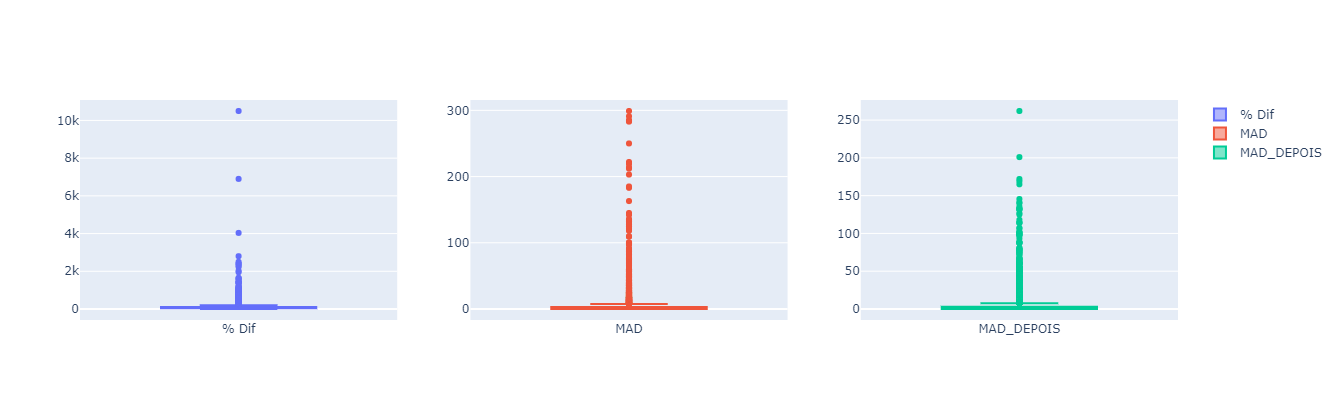

In [187]:
fig = make_subplots(rows = 1, cols = 3)
fig.add_trace(go.Box(y = dataset['% Dif'], name = '% Dif'), row = 1, col = 1)
fig.add_trace(go.Box(y = dataset['MAD'], name = 'MAD'), row = 1, col = 2)
fig.add_trace(go.Box(y = dataset['MAD_DEPOIS'], name = 'MAD_DEPOIS'), row = 1, col = 3)
fig.update_layout(height = 400, width = 800)

In [188]:
z = np.abs(stats.zscore(dataset['MAD']))

In [189]:
dataset2 = dataset[(z<=2)]

In [190]:
z2 = np.abs(stats.zscore(dataset2['MAD_DEPOIS']))

In [191]:
df = dataset2[(z2<=2)]

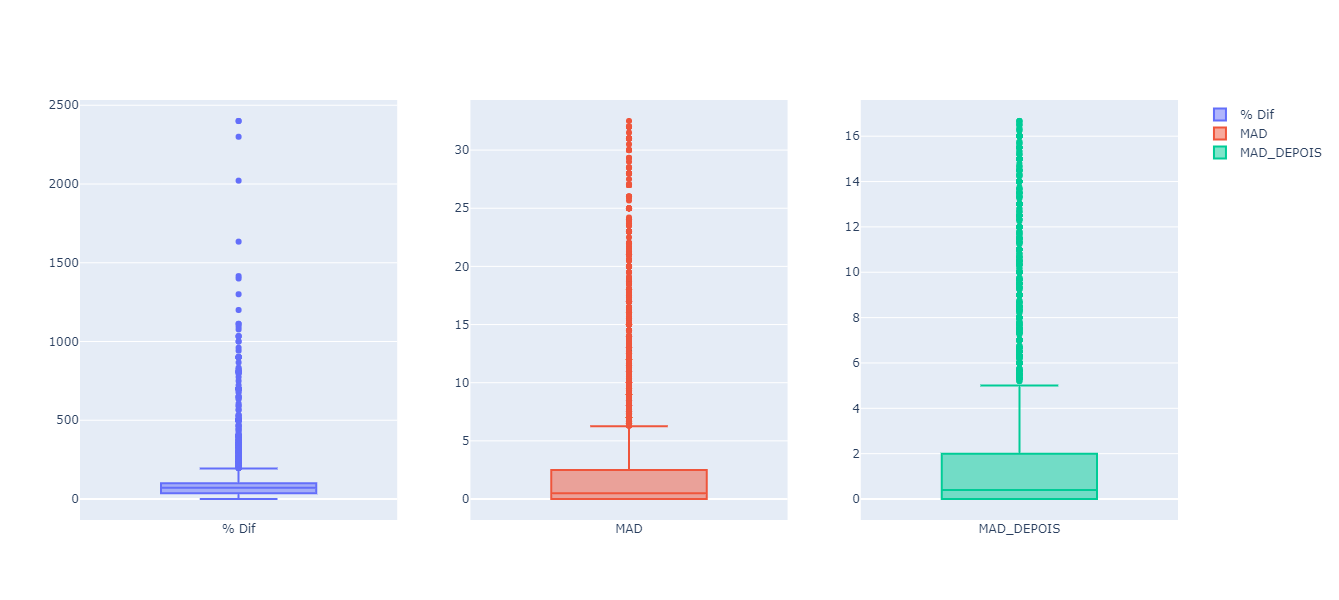

In [192]:
fig = make_subplots(rows = 1, cols = 3)
fig.add_trace(go.Box(y = df['% Dif'], name = '% Dif'), row = 1, col = 1)
fig.add_trace(go.Box(y = df['MAD'], name = 'MAD'), row = 1, col = 2)
fig.add_trace(go.Box(y = df['MAD_DEPOIS'], name = 'MAD_DEPOIS'), row = 1, col = 3)
fig.update_layout(height = 600, width = 800)

In [249]:
df.head(10)

DATA_ATUAL DATA_DEPOIS  DIAS    FAZENDA VARIEDADE   PRODUTO  \
0  2019-08-22  2019-08-23     1  BOM JESUS     Tommy    Melaço   
1  2019-09-03  2019-09-04     1  BOM JESUS     Tommy    Melaço   
2  2019-09-23  2019-09-24     1  BOM JESUS     Tommy  BIOFRUIT   
3  2019-09-30  2019-10-02     2  BOM JESUS     Tommy    Melaço   
4  2020-01-14  2020-01-20     6  BOM JESUS     Tommy  BIOFRUIT   
5  2020-01-29  2020-02-05     7  BOM JESUS     Tommy  BIOFRUIT   
6  2020-02-05  2020-02-17    12  BOM JESUS     Tommy  BIOFRUIT   
7  2020-02-05  2020-02-17    12  BOM JESUS     Tommy  BIOFRUIT   
8  2020-03-20  2020-03-30    10  BOM JESUS     Tommy  BIOFRUIT   
9  2020-04-24  2020-04-29     5  BOM JESUS     Tommy  BIOFRUIT   

                              TALHAO                     FASE   MAD  \
0  BOM JESUS - AGD BAHIA-001 - Tommy   CRESCIMENTO VEGETATIVO   0.5   
1  BOM JESUS - AGD BAHIA-001 - Tommy  AMADURECIMENTO DE RAMOS   0.0   
2  BOM JESUS - AGD BAHIA-001 - Tommy  AMADURECIMENTO DE RAMOS   0.5   
3  BOM JESUS - AGD BAHIA-001 - Tommy  AMADURECIMENTO DE RAMOS   1.0   
4  BOM JESUS - AGD BAHIA-001 - Tommy                 FLORAÇÃO   0.2   
5  BOM JESUS - AGD BAHIA-001 - Tommy                      NaN   0.0   
6  BOM JESUS - AGD BAHIA-001 - Tommy                      NaN   0.0   
7  BOM JESUS - AGD BAHIA-001 - Tommy                      NaN   0.0   
8  BOM JESUS - AGD BAHIA-001 - Tommy                      NaN  24.0   
9  BOM JESUS - AGD BAHIA-001 - Tommy                 COLHEITA   5.5   

   MAD_DEPOIS  DIFERENCA_ABSOLUTA RESULTADO_MAD       % Dif  
0        1.00                0.50      AUMENTOU  100.000000  
1        0.00                0.00         IGUAL         NaN  
2        0.00                0.50       REDUZIU  100.000000  
3        0.00                1.00       REDUZIU  100.000000  
4        0.00                0.20       REDUZIU  100.000000  
5        0.00                0.00         IGUAL         NaN  
6        0.08                0.08      AUMENTOU         inf  
7        0.08                0.08      AUMENTOU         inf  
8        2.00               22.00       REDUZIU   91.666667  
9        2.80                2.70       REDUZIU   49.090909

***
# Análise
***

## Histograma 

In [193]:
filtro = df['MAD'] != 0 
df_filtro = df[filtro]

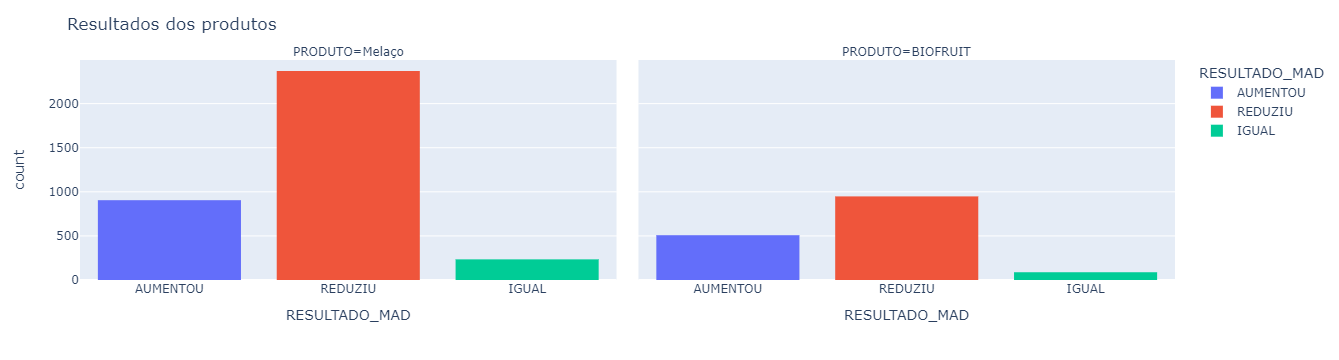

In [359]:
fig = px.histogram(df_filtro, x = 'RESULTADO_MAD', facet_col = 'PRODUTO', color = 'RESULTADO_MAD')
fig.update_layout(height = 300, width = 700, title = 'Resultados dos produtos')

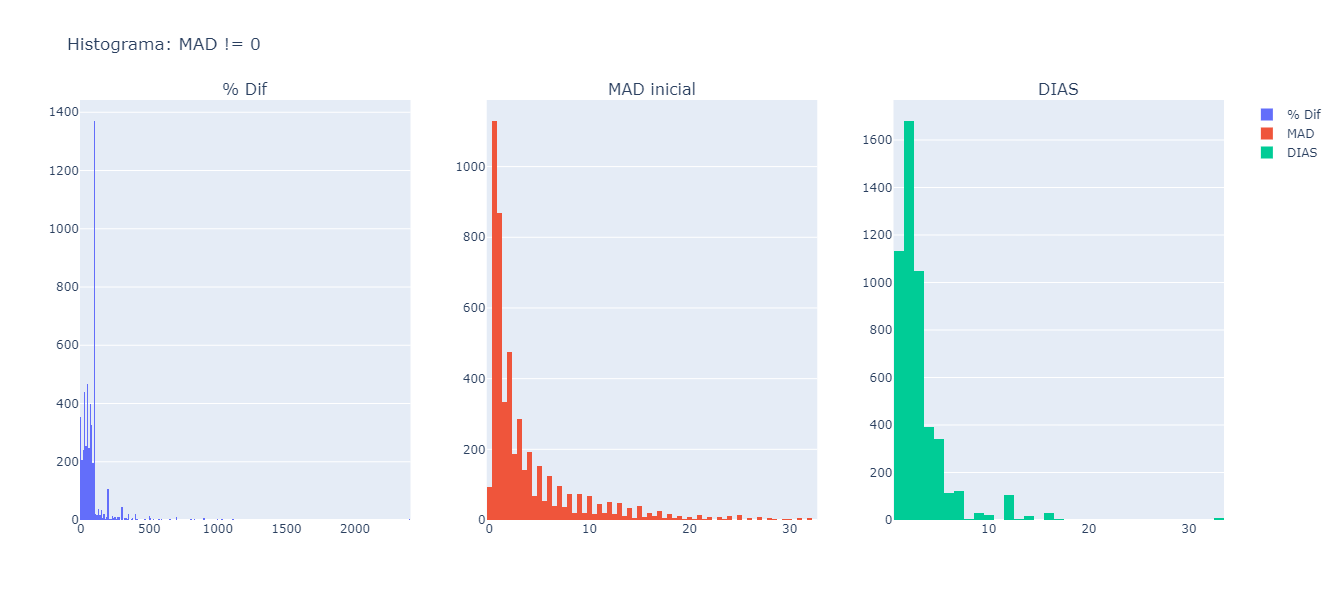

In [346]:
fig = make_subplots(rows = 1, cols = 3, subplot_titles=("% Dif", "MAD inicial", "DIAS"))
fig.add_trace(go.Histogram(x = df_filtro['% Dif'], name = '% Dif'), row = 1, col = 1)
fig.add_trace(go.Histogram(x = df_filtro['MAD'], name = 'MAD'), row = 1, col = 2)
fig.add_trace(go.Histogram(x = df_filtro['DIAS'], name = 'DIAS'), row = 1, col = 3)
fig.update_layout(height = 600, width = 800, title_text = 'Histograma: MAD != 0 ' )

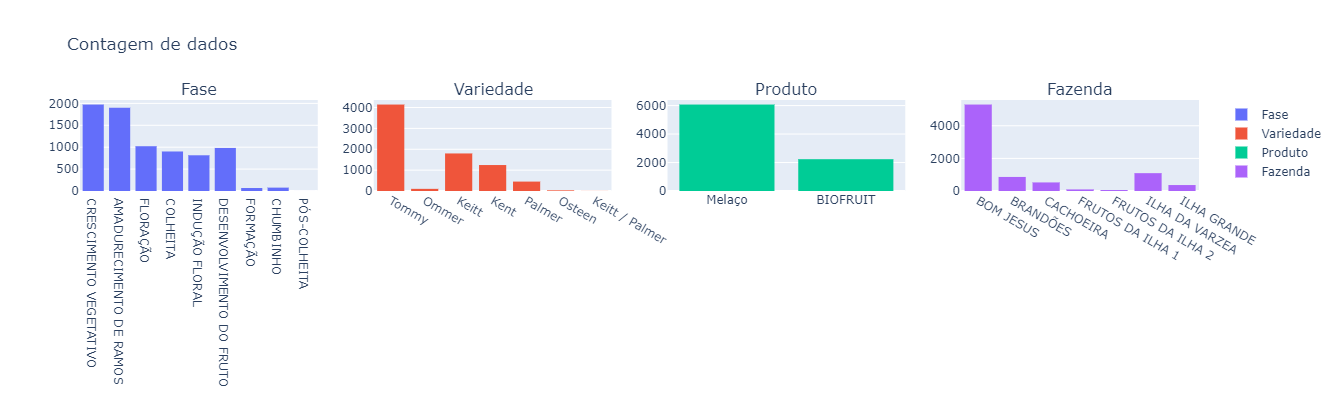

In [195]:
fig = make_subplots(rows = 1, cols = 4, subplot_titles = ('Fase','Variedade','Produto','Fazenda'))
fig.add_trace(go.Histogram(x = df['FASE'], name = 'Fase'), row = 1, col = 1)
fig.add_trace(go.Histogram(x = df['VARIEDADE'], name = 'Variedade'), row = 1, col = 2)
fig.add_trace(go.Histogram(x = df['PRODUTO'], name = 'Produto'), row = 1, col = 3)
fig.add_trace(go.Histogram(x = df['FAZENDA'], name = 'Fazenda'), row = 1, col = 4)
fig.update_layout(height = 400, width = 1000, title_text = 'Contagem de dados')

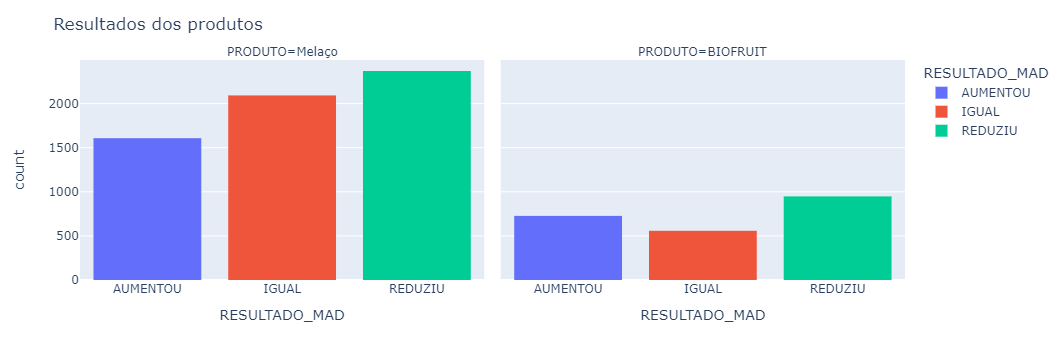

In [196]:
fig = px.histogram(df, x = 'RESULTADO_MAD', facet_col = 'PRODUTO', color = 'RESULTADO_MAD')
fig.update_layout(height = 300, width = 700, title = 'Resultados dos produtos')

## Proporção % Reduzida VS % Aumentada

In [197]:
filtro_melaço = df['PRODUTO'] == 'Melaço'
df_mel = df[filtro_melaço]

filtro_bio = df['PRODUTO'] == 'BIOFRUIT'
df_bio = df[filtro_bio]

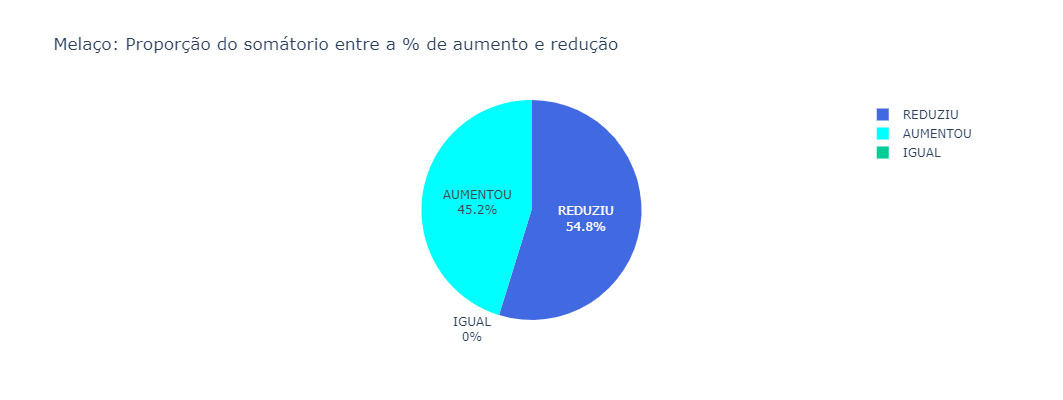

In [198]:
fig = px.pie(df_mel, values='% Dif', names='RESULTADO_MAD', color = 'RESULTADO_MAD',
             color_discrete_map={'REDUZIU':'royalblue',
                                 'AUMENTOU':'cyan'}, title = 'Melaço: Proporção do somátorio entre a % de aumento e redução')
fig.update_traces( textinfo='percent+label' )
fig.update_layout(height = 400, width = 600)

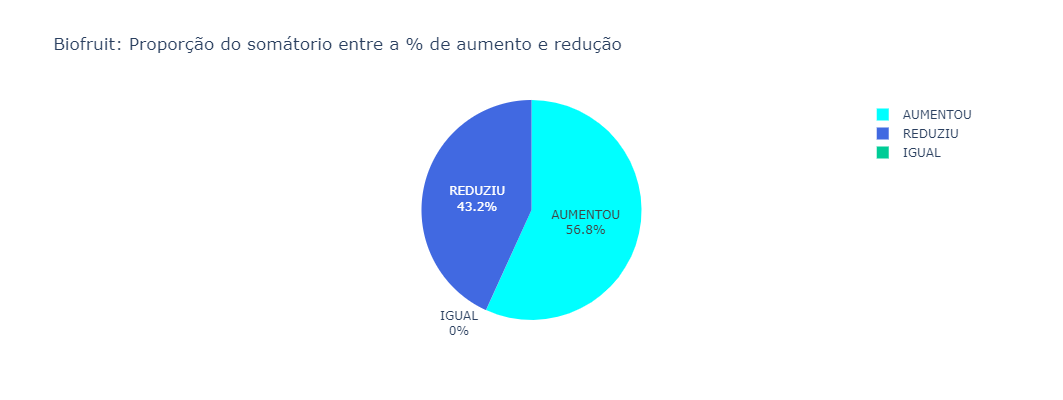

In [199]:
fig = px.pie(df_bio, values='% Dif', names='RESULTADO_MAD', color = 'RESULTADO_MAD',
             color_discrete_map={'REDUZIU':'royalblue',
                                 'AUMENTOU':'cyan'}, title = 'Biofruit: Proporção do somátorio entre a % de aumento e redução')
fig.update_traces( textinfo='percent+label' )
fig.update_layout(height = 400, width = 600)

In [200]:
## Somatorio de reduziu teve uma proporção maior para o MEL
## MEu somatorio de % de aumento do mad foi de 139.105,86 e de redução foi 168.530,47
# Pegando compensação entre a % somada de aumento que aumentou e % que reduziu,
## temos que o melaço compensou teve 9,6% a mais de redução em relação ao aumento

## Somatorio de reduziu teve uma proporção maior para o BIO
## MEu somatorio de % de aumento do mad foi de 83.207,46 e de redução foi 63.277,59
# ja o biofruit nao compensou muito uma vez que tive um somatorio de % de aumento maior que redução em
## 13,6%

In [201]:
## Média de MAD em que os produtos são utilizados

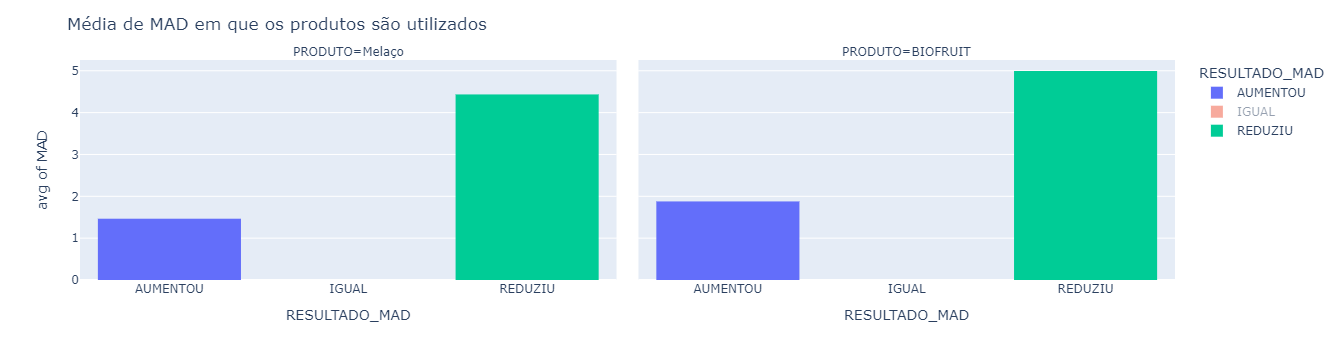

In [202]:
fig = px.histogram(df, x = 'RESULTADO_MAD', y = 'MAD', facet_col = 'PRODUTO', color = 'RESULTADO_MAD', histfunc = 'avg')
fig.update_layout(height = 300, width = 700, title = 'Média de MAD em que os produtos são utilizados')

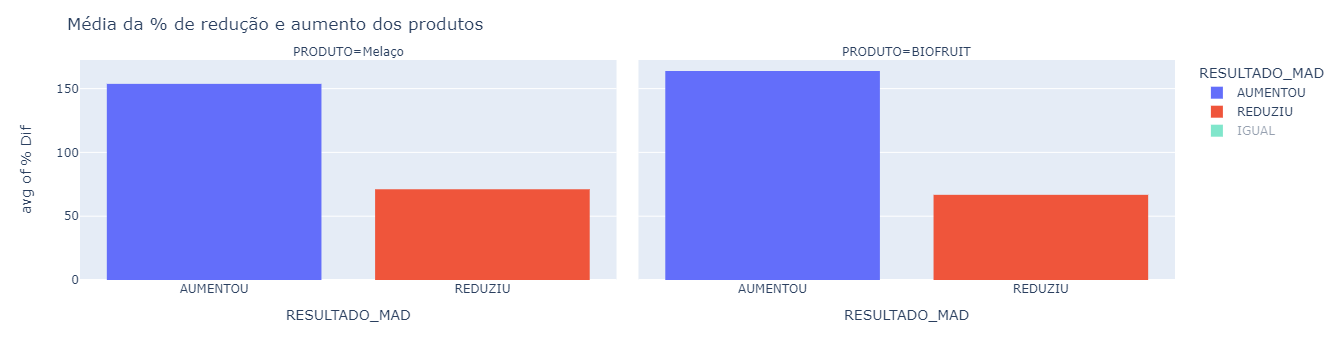

In [203]:
fig = px.histogram(df_filtro, x = 'RESULTADO_MAD', y = '% Dif', facet_col = 'PRODUTO', color = 'RESULTADO_MAD', histfunc = 'avg')
fig.update_layout(height = 300, width = 700,  title = 'Média da % de redução e aumento dos produtos')

In [204]:
## Melaço tem em média reduções percentuais maiores do que o biofruit e aumentos percentuais menores

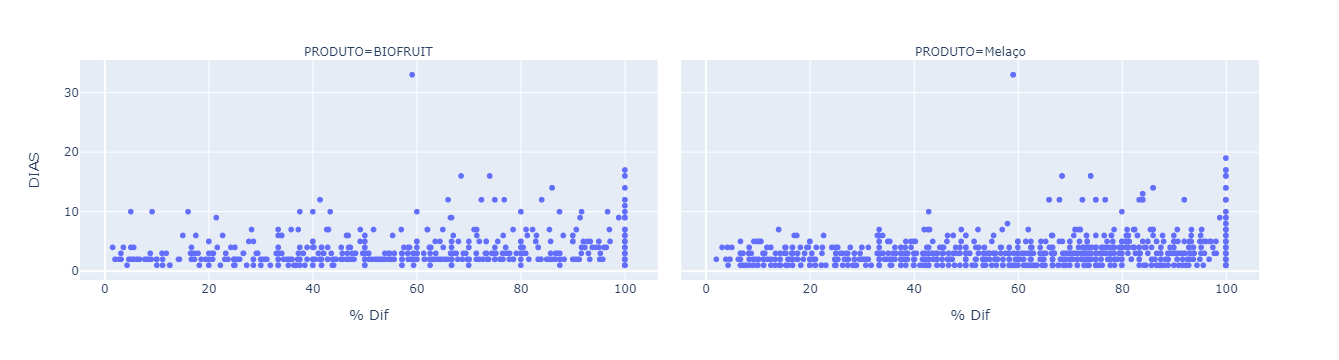

In [333]:
px.scatter(df_redu, x = '% Dif', y = 'DIAS', facet_col = 'PRODUTO', hover_name = 'MAD')

In [332]:
## Comportamento similar em relação ao desempenho com base no dia utilizado

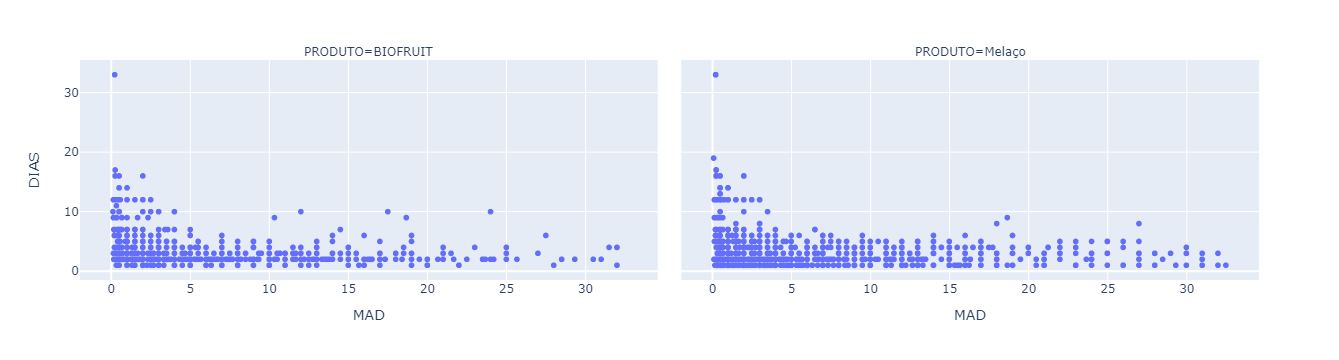

In [338]:
px.scatter(df_redu, x = 'MAD', y = 'DIAS', facet_col = 'PRODUTO', hover_name = '% Dif')

In [336]:
# Comportamento similar em relação aos valores de MAD e dias em que os produtos são utilizados.
# Demora de agir em MADs menores, ali de 5 para baixo.

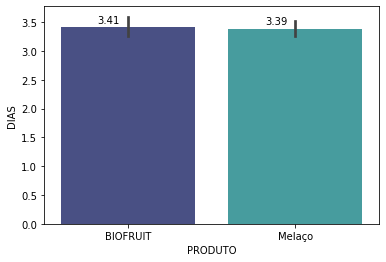

In [343]:
show_values(sn.barplot(x = df_redu['PRODUTO'], y = df_redu['DIAS'], palette = 'mako'))

***
# Significância
***

***
## Análise Visual
***

In [205]:
filtro_redu = df['RESULTADO_MAD'] == 'REDUZIU'
df_redu = df[filtro_redu]

Text(0.5, 1.0, 'IC - 95% % Redução - Produtos')

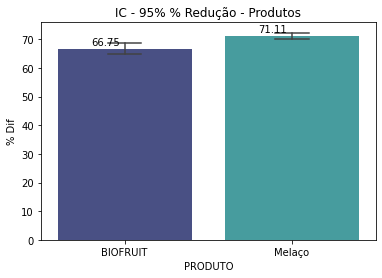

In [206]:
show_values(sn.barplot(x = df_redu['PRODUTO'], y = df_redu['% Dif'], palette = 'mako',errwidth = 1.5, capsize = 0.2))
plt.title('IC - 95% % Redução - Produtos')

In [247]:
df_redu.head(5)

DATA_ATUAL DATA_DEPOIS  DIAS    FAZENDA VARIEDADE   PRODUTO  \
2  2019-09-23  2019-09-24     1  BOM JESUS     Tommy  BIOFRUIT   
3  2019-09-30  2019-10-02     2  BOM JESUS     Tommy    Melaço   
4  2020-01-14  2020-01-20     6  BOM JESUS     Tommy  BIOFRUIT   
8  2020-03-20  2020-03-30    10  BOM JESUS     Tommy  BIOFRUIT   
9  2020-04-24  2020-04-29     5  BOM JESUS     Tommy  BIOFRUIT   

                              TALHAO                     FASE   MAD  \
2  BOM JESUS - AGD BAHIA-001 - Tommy  AMADURECIMENTO DE RAMOS   0.5   
3  BOM JESUS - AGD BAHIA-001 - Tommy  AMADURECIMENTO DE RAMOS   1.0   
4  BOM JESUS - AGD BAHIA-001 - Tommy                 FLORAÇÃO   0.2   
8  BOM JESUS - AGD BAHIA-001 - Tommy                      NaN  24.0   
9  BOM JESUS - AGD BAHIA-001 - Tommy                 COLHEITA   5.5   

   MAD_DEPOIS  DIFERENCA_ABSOLUTA RESULTADO_MAD       % Dif  
2         0.0                 0.5       REDUZIU  100.000000  
3         0.0                 1.0       REDUZIU  100.000000  
4         0.0                 0.2       REDUZIU  100.000000  
8         2.0                22.0       REDUZIU   91.666667  
9         2.8                 2.7       REDUZIU   49.090909

In [285]:
#df_redu.to_excel('So_redu.xlsx')

In [207]:
#show_values(sn.barplot(x = df_redu['PRODUTO'], y = df_redu['MAD'], palette = 'mako',errwidth = 1.5, capsize = 0.2))
#plt.title('IC - 95% MAD em que os produtos são utilizados')

In [208]:
## Pelos ICS, percebe-se que existe diferença significativa entre as médias dos percentuais de redução entre os produtos
## O melaço tem reduções percentuais maiores do que o Biofruit

***
## Análise numérica
***

In [209]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [210]:
import statsmodels.stats.anova as sma
import statsmodels.formula.api as smf

In [211]:
df_redu['PRODUTO'].value_counts()

Melaço      2370
BIOFRUIT     948
Name: PRODUTO, dtype: int64

In [212]:
tukey = pairwise_tukeyhsd(endog = df_redu['% Dif'],
                         groups = df_redu['PRODUTO'],
                         alpha = 0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
 group1  group2 meandiff p-adj lower  upper  reject
---------------------------------------------------
BIOFRUIT Melaço   4.3614 0.001 2.1635 6.5593   True
---------------------------------------------------


In [213]:
filtro_11 = df_redu['PRODUTO'] == 'BIOFRUIT'
filtro_22 = df_redu['PRODUTO'] == 'Melaço'

df_cor_11 = df_redu[filtro_11]
df_cor_22 = df_redu[filtro_22]

print(f_oneway(df_cor_11['% Dif'], df_cor_22['% Dif']))

F_onewayResult(statistic=15.137860140046596, pvalue=0.00010190196334148884)


In [214]:
## Existe diferença significativa na % de 
## redução entre a utilização do Biofruit e Melaço

***
#### Df_redu com mesmo tamanho amostral
***

In [317]:
amostra_redu = pd.read_excel('So_redu.xlsx', sheet_name = 'amostras_iguais')

In [318]:
amostra_redu['PRODUTO'].value_counts()

BIOFRUIT    948
Melaço      948
Name: PRODUTO, dtype: int64

In [319]:
import pingouin as pg
aov = pg.anova(dv = '% Dif', between = 'PRODUTO', data = amostra_redu, detailed = True)
aov

Source            SS    DF           MS         F     p-unc       np2
0  PRODUTO  8.954390e+03     1  8954.389989  10.45147  0.001247  0.005488
1   Within  1.622701e+06  1894   856.758879       NaN       NaN       NaN

In [320]:
filtro_11 = amostra_redu['PRODUTO'] == 'BIOFRUIT'
filtro_22 = amostra_redu['PRODUTO'] == 'Melaço'

df_cor_11 = amostra_redu[filtro_11]
df_cor_22 = amostra_redu[filtro_22]

print(f_oneway(df_cor_11['% Dif'], df_cor_22['% Dif']))

F_onewayResult(statistic=10.451470313660597, pvalue=0.001246586082539907)


Text(0.5, 1.0, 'IC - 95%')

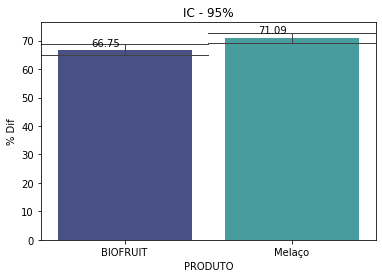

In [347]:
show_values(sn.barplot(x = amostra_redu['PRODUTO'], y = amostra_redu['% Dif'], 
                       errwidth = 1, capsize = 1, palette = 'mako'))
plt.title('IC - 95%')

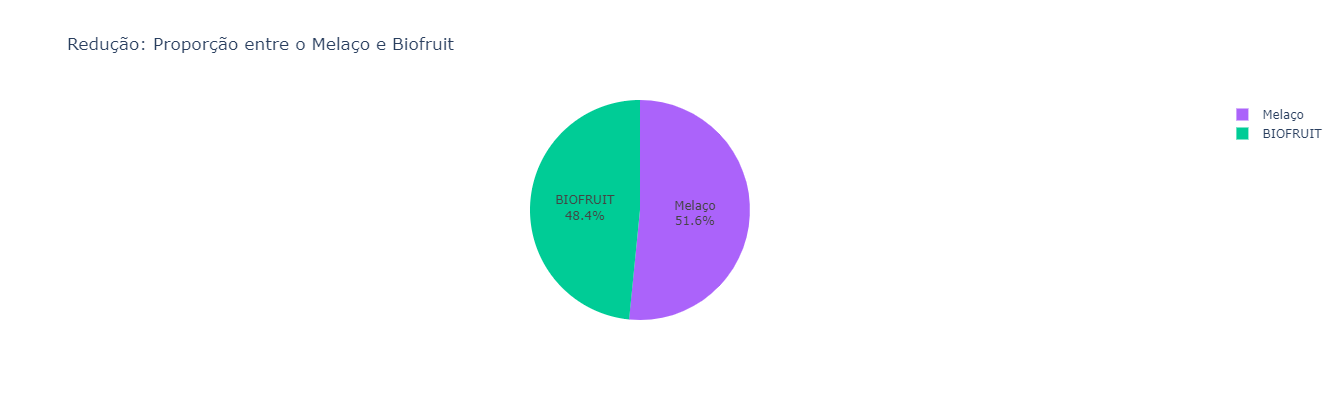

In [349]:
fig = px.pie(amostra_redu, values='% Dif', names='PRODUTO', color = 'PRODUTO',
             color_discrete_map={'REDUZIU':'royalblue',
                                 'AUMENTOU':'cyan'}, title = 'Redução: Proporção entre o Melaço e Biofruit')
fig.update_traces( textinfo='percent+label' )
fig.update_layout(height = 400, width = 600)

In [323]:
# Isso significa que temos evidências suficientes, com esses dados, para dizer que o melaço resulta em reduções percentuais melhores do que as reduções do biofruit.
# Pouco mais é

***
## Análise significância no aumento
***

In [215]:
filtro_aum = df['RESULTADO_MAD'] == 'AUMENTOU'
df_aum = df[filtro_aum]

In [216]:
filtro_aum2 = df_aum['MAD'] != 0
df_aum2 = df_aum[filtro_aum2]

In [217]:
df_aum2['PRODUTO'].value_counts()

Melaço      905
BIOFRUIT    508
Name: PRODUTO, dtype: int64

In [298]:
#df_aum2.to_excel('So_aum.xlsx')

In [218]:
filtro_11 = df_aum2['PRODUTO'] == 'BIOFRUIT'
filtro_22 = df_aum2['PRODUTO'] == 'Melaço'

df_cor_11 = df_aum2[filtro_11]
df_cor_22 = df_aum2[filtro_22]

print(f_oneway(df_cor_11['% Dif'], df_cor_22['% Dif']))

F_onewayResult(statistic=0.6679009130317194, pvalue=0.4139223715635779)


In [219]:
tukey = pairwise_tukeyhsd(endog = df_aum2['% Dif'],
                         groups = df_aum2['PRODUTO'],
                         alpha = 0.05)
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower    upper  reject
-------------------------------------------------------
BIOFRUIT Melaço -10.0861 0.4139 -34.2957 14.1235  False
-------------------------------------------------------


In [220]:
## A diferença do aumento não é significativo, ou seja
## Existe diferença estatistica entre as médias de reduçoes
## mas não existe entre o aumento
## Os produtos aumentam em proporções semelhantes
## mas reduzem em proporcoes diferentes

Text(0.5, 1.0, 'IC 95% % Aumento produto')

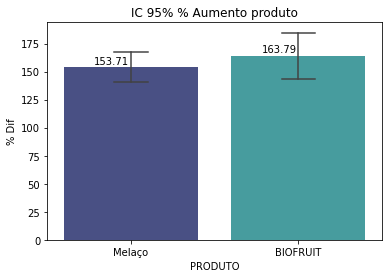

In [221]:
show_values(sn.barplot(x = df_aum2['PRODUTO'], y = df_aum2['% Dif'], palette = 'mako',errwidth = 1.5, capsize = 0.2))
plt.title('IC 95% % Aumento produto')

In [299]:
amostra_aumento = pd.read_excel('So_aum.xlsx', sheet_name = 'amostra_igual')

In [300]:
amostra_aumento['PRODUTO'].value_counts()

BIOFRUIT    508
Melaço      508
Name: PRODUTO, dtype: int64

In [301]:
filtro_11 = amostra_aumento['PRODUTO'] == 'BIOFRUIT'
filtro_22 = amostra_aumento['PRODUTO'] == 'Melaço'

df_cor_11 = amostra_aumento[filtro_11]
df_cor_22 = amostra_aumento[filtro_22]

print(f_oneway(df_cor_11['% Dif'], df_cor_22['% Dif']))

F_onewayResult(statistic=1.8013435091779846, pvalue=0.17985058403543602)


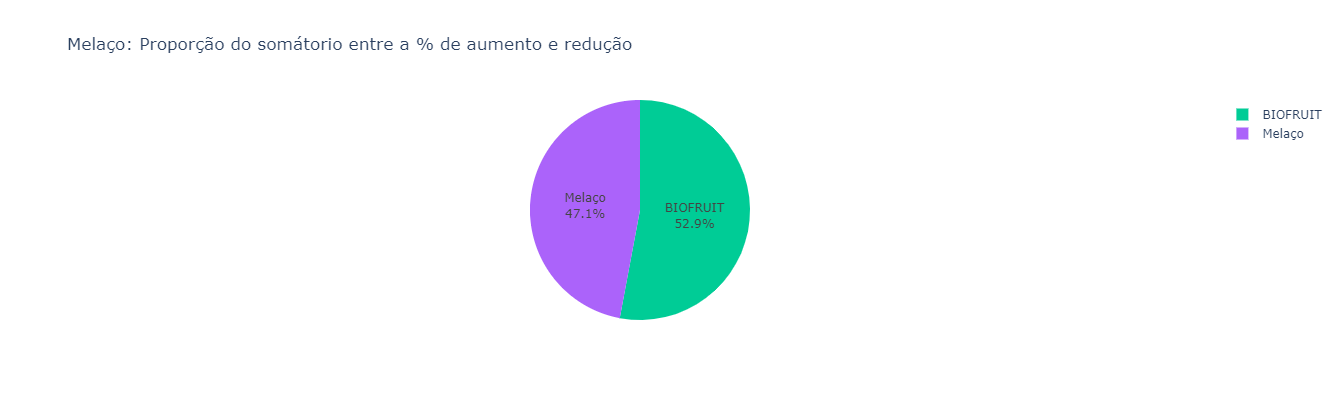

In [305]:
fig = px.pie(amostra_aumento, values='% Dif', names='PRODUTO', color = 'PRODUTO',
             color_discrete_map={'REDUZIU':'royalblue',
                                 'AUMENTOU':'cyan'}, title = 'Melaço: Proporção do somátorio entre a % de aumento e redução')
fig.update_traces( textinfo='percent+label' )
fig.update_layout(height = 400, width = 600)

Text(0.5, 1.0, 'IC 95% % Aumento produto')

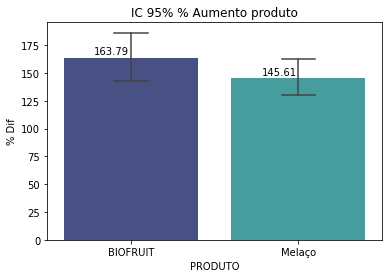

In [306]:
show_values(sn.barplot(x = amostra_aumento['PRODUTO'], y = amostra_aumento['% Dif'], palette = 'mako',errwidth = 1.5, capsize = 0.2))
plt.title('IC 95% % Aumento produto')

***
# Analisando Probabilidades
***

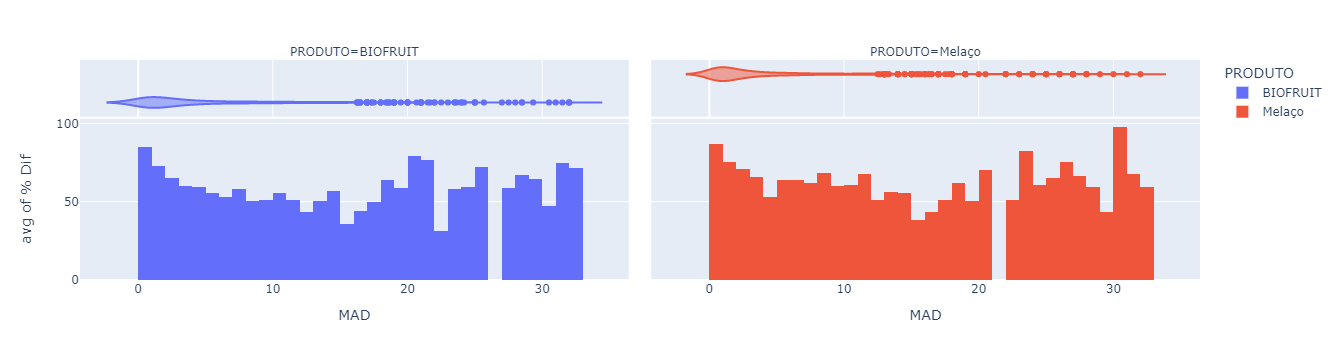

In [355]:
px.histogram(amostra_redu, x = 'MAD', facet_col = 'PRODUTO', marginal = 'violin', color = 'PRODUTO', y = '% Dif', histfunc = 'avg')

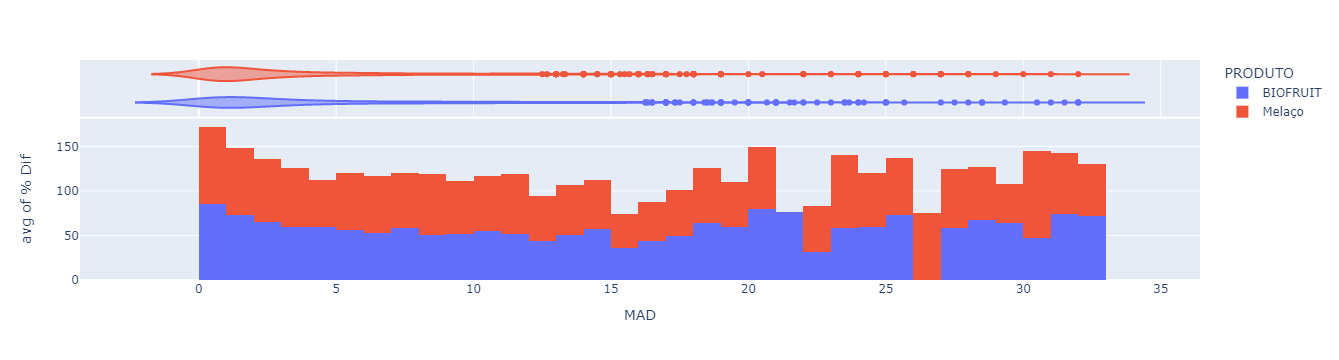

In [353]:
px.histogram(amostra_redu, x = 'MAD', color = 'PRODUTO', marginal = 'violin', y = '% Dif', histfunc = 'avg')

In [ ]:
  # Para uma redução em um intervalo MAD entre 0.25 e 0.74 tem-se uma probabilidade de 68% para ocorrer uma redução média de 85.74% do valor incial do MAD. biofruit
  # Para uma redução em um intervalo MAD entre 0.25 e 0.74 tem-se uma probabilidade de 90% para ocorrer uma redução média de 87.8% do valor incial do MAD. melaço

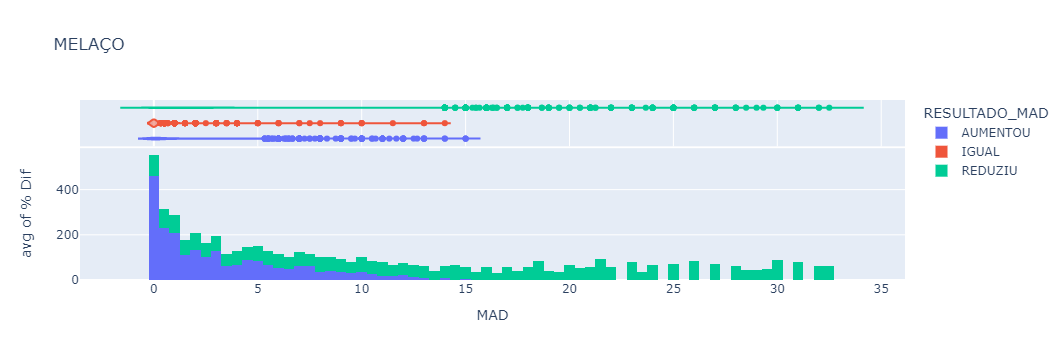

In [224]:
px.histogram(df_mel, x = 'MAD', y = '% Dif', color = 'RESULTADO_MAD', marginal = 'violin', histfunc = 'avg', title = 'MELAÇO')

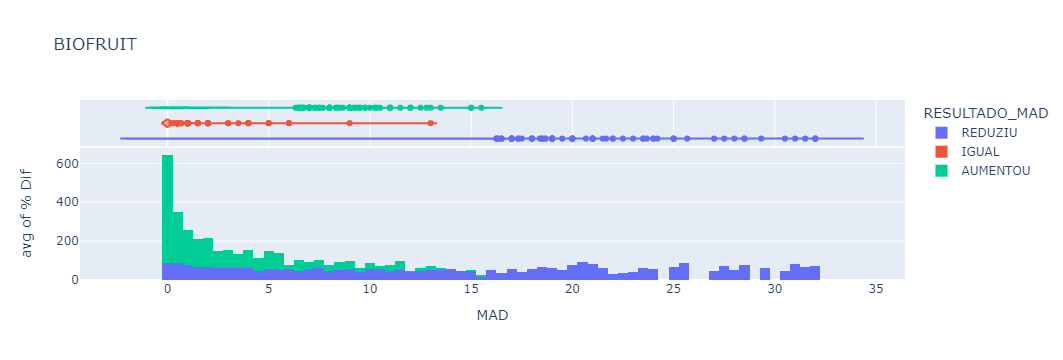

In [225]:
px.histogram(df_bio, x = 'MAD', y = '% Dif', color = 'RESULTADO_MAD', marginal = 'violin', histfunc = 'avg', title = 'BIOFRUIT')

In [226]:
## Maior probabilidade de redução do MAD quando usar o melaço entre 0.25 e 1.8
## Maior probabilidade de redução com o Biofruit quando usar a um MAD de 0.20 e 2.4

## Probabilidade de reduções percentuais em MAD's maiores é maior para o BIOFRUIT 
## Porém, o melaço reduz em % maiores do que o o Biofruit

## Para um mAD entre 1.75 e 2.24 

## A probabilidade de aplicar o MELAÇO para um MAD de entre 1.75 e 2.24, ocorrer uma redução e ter em média uma redução de 72,5% do valor do MAD inicial, é de 73%

## A probabilidade de aplicar o BIOFRUIT para um MAD entre 1.75 e 2.24, ocorrer uma redução e ter em média de 65.25% do valor do MAD inicial 66%


## 
# MELAÇO:
    # Para uma redução em um intervalo MAD entre 1.75 e 2.24 tem-se uma probabilidade de 73% para ocorrer uma redução média de 72.5% do valor incial do MAD.
    # Para uma redução em um intervalo MAD entre 0.25 e 0.74 tem-se uma probabilidade de 90% para ocorrer uma redução média de 87.8% do valor incial do MAD.
# BIOFRUIT:
    # Para uma redução em um intervalo MAD entre 1.75 e 2.24 tem-se uma probabilidade de 65% para ocorrer uma redução média de 65.25% do valor incial do MAD.
    # Para uma redução em um intervalo MAD entre 0.25 e 0.74 tem-se uma probabilidade de 68% para ocorrer uma redução média de 85.74% do valor incial do MAD.

In [229]:
df_sem_out = df.dropna()

***
# Análise por FASE
***

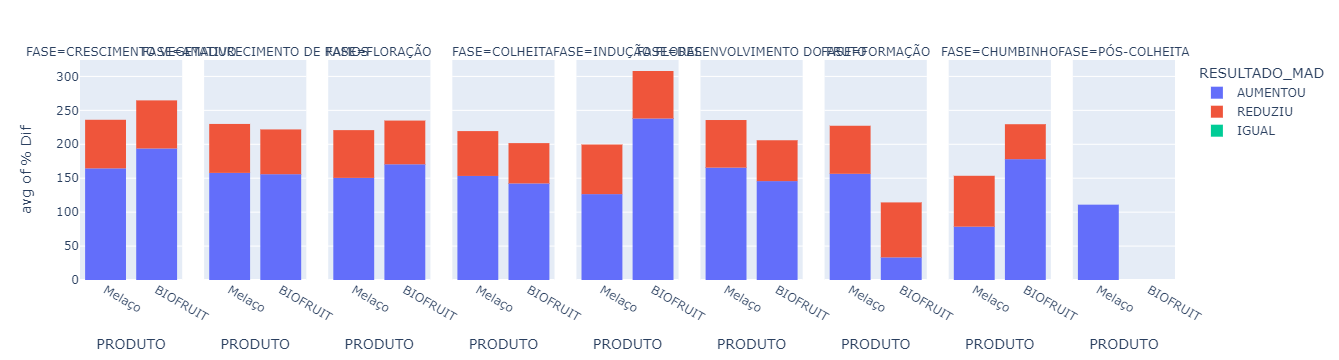

In [356]:
fig = px.histogram(df_sem_out, x = 'PRODUTO', facet_col = 'FASE', color = 'RESULTADO_MAD', y = '% Dif', histfunc = 'avg')
fig.update_layout(height = 300, width = 1400)

Text(0.5, 1.0, 'IC 95% % Aumento produto')

posx and posy should be finite values
posx and posy should be finite values


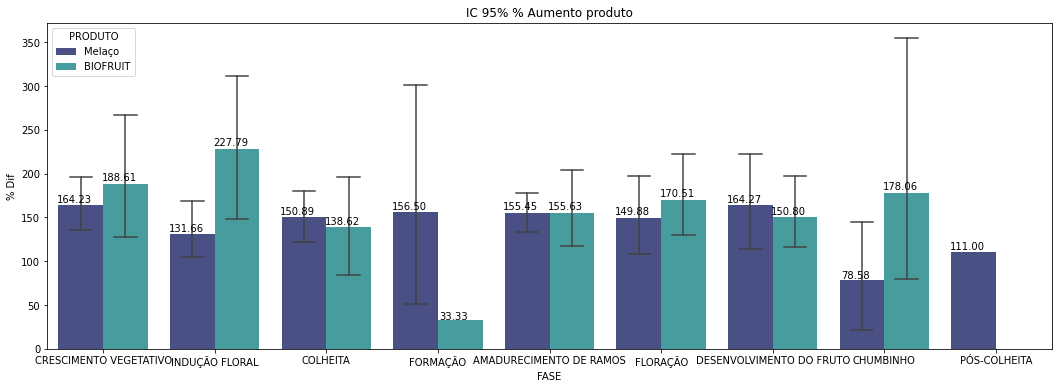

In [231]:
plt.figure(figsize=(18,6))
show_values(sn.barplot(x = df_aum2['FASE'], y = df_aum2['% Dif'], hue = df_aum2['PRODUTO'], palette = 'mako',errwidth = 1.5, capsize = 0.2))
plt.title('IC 95% % Aumento produto')

In [232]:
## Diferenças de aumento por fases não são significativas 

Text(0.5, 1.0, 'IC 95% % Redução produto')

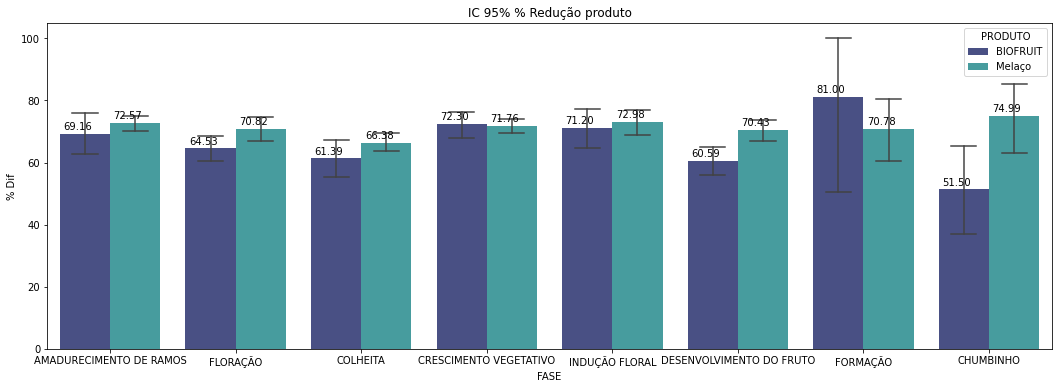

In [358]:
plt.figure(figsize=(18,6))
show_values(sn.barplot(x = df_redu['FASE'], y = df_redu['% Dif'], hue = df_redu['PRODUTO'], palette = 'mako',errwidth = 1.5, capsize = 0.2))
plt.title('IC 95% % Redução produto')

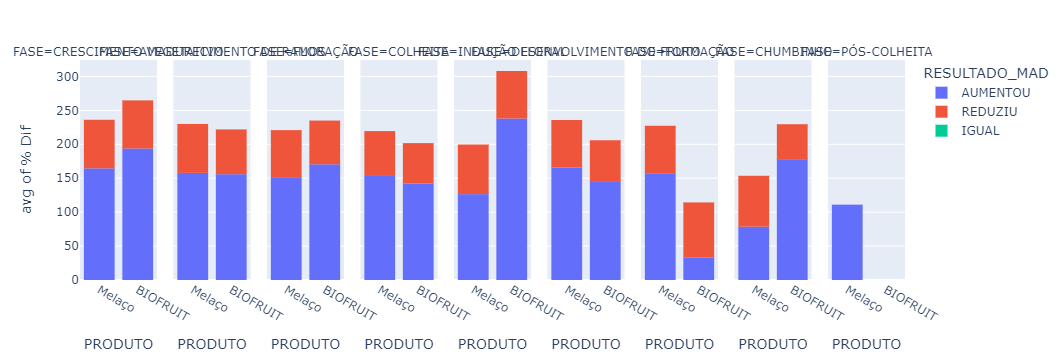

In [234]:
fig = px.histogram(df_sem_out, x = 'PRODUTO', facet_col = 'FASE', color = 'RESULTADO_MAD', y = '% Dif', histfunc = 'avg')
fig.update_layout(height = 300, width = 1200)